O NMF fatora uma matriz de entrada, 𝕍, em um produto de duas matrizes menores, 𝕎 e ℍ, de forma que essas três matrizes não tenham valores negativos.

No contexto da NLP, essas três matrizes têm os seguintes significados:



*   A matriz de entrada 𝕍 é a contagem de termos (Tokens) ou matriz tf-idf de tamanho n × m, onde n é o número de documentos ou amostras e m é o número de termos.
*   A primeira matriz de saída de decomposição 𝕎 é a matriz de características (features) de tamanho t × m, onde t é o número de tópicos especificados. Cada linha de 𝕎 representa um tópico com cada elemento da linha representando rank ou score de um termo no tópico.
*   A segunda matriz de saída de decomposição ℍ é a matriz de coeficientes de tamanho n × t. Cada linha de ℍ representa um documento, com cada elemento da linha representando o peso de um tópico dentro do documento.

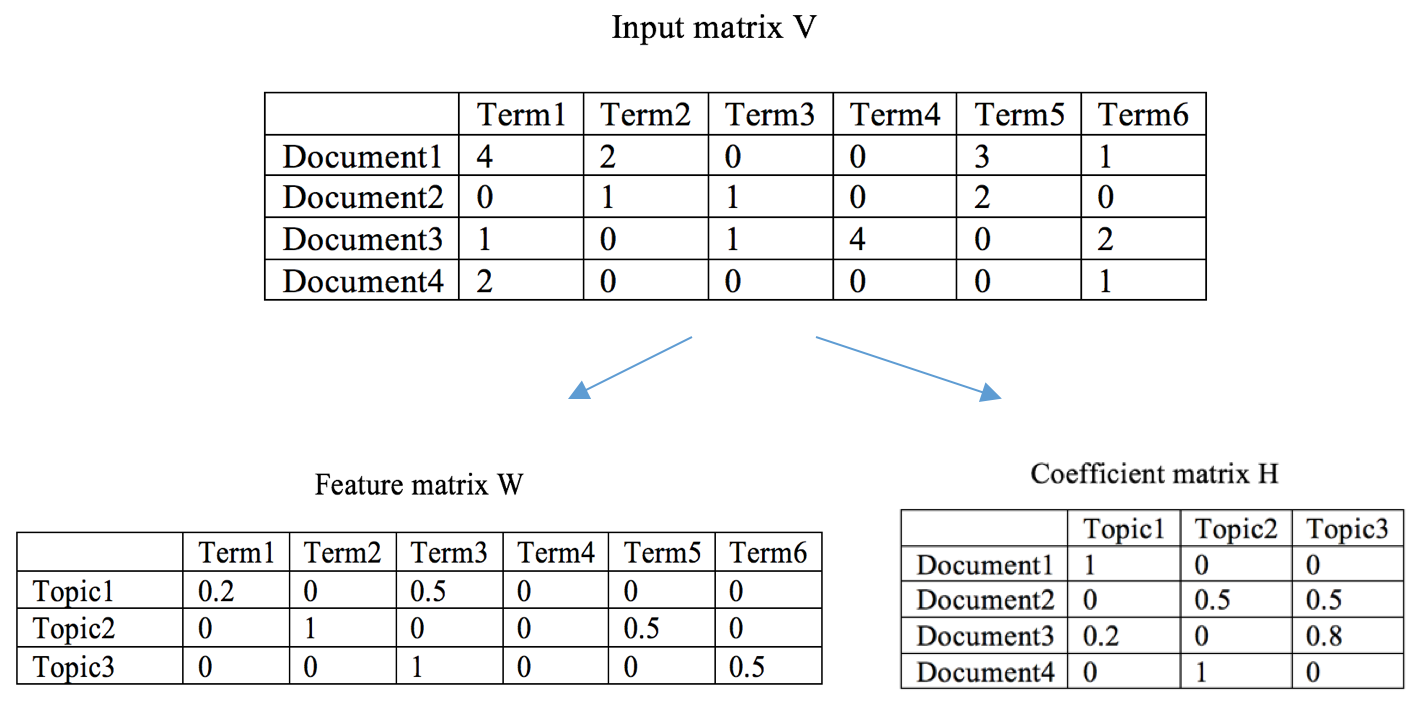



In [ ]:
from sklearn.datasets import fetch_20newsgroups
import nltk
nltk.download('wordnet')
nltk.download('names')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import names
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import re
import string
import numpy as np

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
cat = ['alt.atheism', 'talk.religion.misc', 'comp.graphics',
       'sci.space']

dataset = fetch_20newsgroups(subset='all', categories=cat)
labels = dataset.target
label_names = dataset.target_names

In [ ]:
words_to_exclude = ['nntppostinghost', 'line', 'email', 'dont', 'newsgroups']

def get_lemmatized_data(data: list) -> np.array:
  data_proc = []
  lemmatizer = WordNetLemmatizer()
  for doc in data:
    doc = doc.lower()
    doc_lem = ' '.join(lemmatizer.lemmatize(word) for word in doc.split() if word not in words_to_exclude)
    data_proc.append(doc_lem)
  return np.array(data_proc)

def preproc_20newsgroup(data):
  url_re = re.compile(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
  email_re = re.compile('(?:[a-z0-9!#$%&\'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&\'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])')
  preproc_data = []
  for doc in data:
    # Remover cabeçalho de Email
    doc = re.sub(r'(From:\s+[^\n]+\n)', '', doc)
    doc = re.sub(r'(Subject:[^\n]+\n)', '', doc)
    doc = re.sub(r'(([\sA-Za-z0-9\-]+)?[A|a]rchive-name:[^\n]+\n)', '', doc)
    doc = re.sub(r'(Last-modified:[^\n]+\n)', '', doc)
    doc = re.sub(r'(Version:[^\n]+\n)', '', doc)

    doc = doc.lower()
    doc = re.sub(url_re, '', doc)
    doc = re.sub(email_re, '', doc)
    doc = re.sub(f'[{re.escape(string.punctuation)}]', '', doc)
    doc = re.sub(r'(\d+)', ' ', doc)
    doc = re.sub(r'(\s+)', ' ', doc)
    preproc_data.append(doc)
  get_lemmatized_data(preproc_data)
  return preproc_data

In [ ]:
preproc_transformer = FunctionTransformer(preproc_20newsgroup)
preproc_pipeline = Pipeline([('preproc_20groups', preproc_transformer),
                             ('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english'))])

vect_data = preproc_pipeline.fit_transform(dataset.data)

In [ ]:
vect_data.shape

(3387, 21408)

In [ ]:
from sklearn.decomposition import NMF

topicos = 4
nmf = NMF(n_components=topicos, random_state=42, max_iter=500)

In [ ]:
nmf.fit(vect_data)

NMF(max_iter=500, n_components=4, random_state=42)

In [ ]:
W = nmf.components_
W

array([[3.80380083e-02, 1.25406906e-03, 2.50813812e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.64320521e-03, 4.98909295e-05, 9.97818590e-05, ...,
        4.98978424e-03, 3.08431709e-03, 1.37623496e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.46112380e-04, 4.14345664e-05, 0.00000000e+00],
       [4.45102354e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
W.shape

(4, 21408)

In [ ]:
palavras = preproc_pipeline['tfidf'].get_feature_names_out()

for topico_id, topic in enumerate(W):
  print(f"As 10 palavras mais frequentes do Tópico {topico_id}")
  print(" ".join([palavras[i] for i in topic.argsort()[-10:]]))

As 10 palavras mais frequentes do Tópico 0
article say religion christian dont bible believe people jesus god
As 10 palavras mais frequentes do Tópico 1
program email format bit files file university thanks image graphics
As 10 palavras mais frequentes do Tópico 2
article mission like just moon orbit nasa launch shuttle space
As 10 palavras mais frequentes do Tópico 3
immoral people dont think jon keith values moral morality objective


In [ ]:
H = nmf.transform(vect_data)
H

array([[0.06107932, 0.01067853, 0.00965787, 0.00457023],
       [0.00264147, 0.08227568, 0.00064069, 0.00780492],
       [0.        , 0.05022993, 0.01285826, 0.        ],
       ...,
       [0.00174288, 0.        , 0.12696154, 0.00161874],
       [0.00117617, 0.08551773, 0.01339519, 0.0028724 ],
       [0.        , 0.10881468, 0.0140547 , 0.        ]])

In [ ]:
H.shape

(3387, 4)

In [ ]:
topics = H.argmax(axis=1)

topic_label = {i: labels[np.where(topics == i)] for i in range(H.shape[1])}

for topic, index_list in topic_label.items():
  counter = Counter(topic_label[topic])
  print("=========================")
  print(f'Tópico {topic}: {len(index_list)} amostras')
  for label_index, count in sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True):
    print(f'{label_names[label_index]}: {count} amostras')

Tópico 0: 993 amostras
alt.atheism: 520 amostras
talk.religion.misc: 458 amostras
sci.space: 9 amostras
comp.graphics: 6 amostras
Tópico 1: 1088 amostras
comp.graphics: 940 amostras
sci.space: 71 amostras
talk.religion.misc: 39 amostras
alt.atheism: 38 amostras
Tópico 2: 1009 amostras
sci.space: 903 amostras
talk.religion.misc: 47 amostras
alt.atheism: 34 amostras
comp.graphics: 25 amostras
Tópico 3: 297 amostras
alt.atheism: 207 amostras
talk.religion.misc: 84 amostras
sci.space: 4 amostras
comp.graphics: 2 amostras
